In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import the Support Vector Classifier
import scipy.sparse as sp
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline


In the first place, we will import the data from 4 different text files, merge them and then isolate it into three parts. The three parts are the following:

1-Years 2007-2014, this will be the training set

2-Year 2015, this will be the validation set

3-Year 2016, we will test our model with this years data at the end. 

We will further replace the target variable loan status with 1 for Charged Off and with 0 for Fully Paid. 

We realize that we don't have many missing values and the ones we have are not necessarily so important. For good measure we still drop the columns that have more than 10 percent missing values and rows that have more that 20 percent values. We notice that there aren't any columns nor rows that satisfy these thus we continue with the whole data set. 

In [2]:
df1 = pd.read_csv('Lending_Club_modelling_data_part1.txt', delimiter='\t')
df2 = pd.read_csv('Lending_Club_modelling_data_part2.txt', delimiter='\t', dtype={'column_name': str}, low_memory=False)
df3 = pd.read_csv('Lending_Club_modelling_data_part3.txt', delimiter='\t')
df4 = pd.read_csv('Lending_Club_modelling_data_part4.txt', delimiter='\t')

#merged data
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("Before dropping na: ",df.shape)

# Drop the title column because it is the same information as purpose
df = df.drop('title', axis=1)

# Fill missing values in 'address' column with the wrong address in mort_acc column
df['address'] = df['address'].fillna( '76093 Nicole Parks\r\nEast Donaldfurt, IN 70466')

# Replace missing values in 'emp_title' column with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

#print rows with missing values, show only if different from 0
print(df.isnull().sum()[df.isnull().sum() > 0])

#drop columns with more than 20% missing values
df = df.dropna(thresh=len(df)*0.80, axis=1)
print("After dropping columns na: ",df.shape)

#drop rows with with more than 20% missing values
df = df.dropna(thresh=len(df.columns)*0.80, axis=0)
print("After dropping rows na: ",df.shape)

#replace target variable values with 0 and 1
df['loan_status'] = df['loan_status'].replace({'Charged Off': 1, 'Fully Paid': 0})

# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Replace values in 'emp_length' column with numerical values
emp_length_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}
df['emp_length'] = df['emp_length'].replace(emp_length_map)

# Correct types of columns
df['revol_util'] = df['revol_util'].replace({'f':'NaN'})
df['revol_util'] = df['revol_util'].astype(float)
df['total_acc'] = df['revol_util'].replace({'INDIVIDUAL':'NaN'})
df['total_acc'] = df['total_acc'].astype(float)
df['mort_acc'] = df['mort_acc'].replace({'76093 Nicole Parks\r\nEast Donaldfurt, IN 70466':'NaN'})
df['mort_acc'] = df['mort_acc'].astype(float)

# Separate the data into three groups based on the year ranges
training_set = df[df['issue_d'].dt.year < 2015]
validation_set = df[df['issue_d'].dt.year == 2015]
test_set = df[df['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
training_set.reset_index(drop=True, inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Print the number of rows in each group
print("Number of rows in training set:", training_set.shape)
print("Number of rows in validation set:", validation_set.shape)
print("Number of rows in test set:", test_set.shape)

Before dropping na:  (396030, 25)
emp_length              18301
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      536
dtype: int64
After dropping columns na:  (396030, 24)
After dropping rows na:  (396030, 24)
Number of rows in training set: (273678, 24)
Number of rows in validation set: (94264, 24)
Number of rows in test set: (28088, 24)


# Here we would like to define a Net Profit function

We would like to check how much money was lost and earned with the current situation of given loans. We calculate the profit as 
$$\text{Profit}=\sum_{i\in{\text{Fully Paid}}} \text{loan amount}_i\times\frac{\text{interest rate}_i}{100}$$ 
We further assume that on average, people default after paying half of what was owed i.e. the loss is calculated as 
$$\text{Loss}\sum_{i\in{\text{Charged Off}}} \frac{\text{loan amount}_i}{2}$$
We will try to have a model with custom total loss defined as the negative total profits 
$$ \text{Custom Loss}=-\text{Total Profit}$$
Since we would like to maximize our profits and a loss function is defined as a minimization problem. 

In [3]:
def net_profit(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    int_rate = df['int_rate'].values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = loan_amnt[paid_back_loans] * (int_rate[paid_back_loans] / 100)
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss

In [4]:
zeros = np.zeros(len(training_set))
print(net_profit(zeros,training_set))

33980007.84500003


In [5]:
# Calculate profit for rows where loan_status is "Fully Paid"
df_paid_loans = df[df["loan_status"] == 0].copy()  # Make a copy to avoid SettingWithCopyWarning
df_paid_loans.loc[:, "profit"] = df_paid_loans["loan_amnt"] * (df_paid_loans["int_rate"] / 100)

# Summing up profits to get total profit
total_profit = df_paid_loans["profit"].sum()
print("Total Profit from Fully Paid Loans: $", total_profit)

# Calculate loss for defaulted loans (assuming half is recovered)
df_defaulted_loans = df[df["loan_status"] == 1].copy()
df_defaulted_loans.loc[:, "loss"] = df_defaulted_loans["loan_amnt"] *0.5

# Summing up losses to get total loss
total_loss = df_defaulted_loans["loss"].sum()
print("Total Loss from Charged Off Loans: $", total_loss)

# Calculate net profit
net_profit = total_profit - total_loss
print("Net Profit: $", net_profit)


Total Profit from Fully Paid Loans: $ 593828211.0725001
Total Loss from Charged Off Loans: $ 587452587.5
Net Profit: $ 6375623.57250011


We check how imbalanced the data is. This might have an influance on our approach. We notice that the imblacedness is not drastic. 

In [6]:
df['loan_status'].value_counts()
# Count the occurrences of each class
count_class_0, count_class_1 = df['loan_status'].value_counts()
ratio = count_class_0 / (count_class_1+count_class_0)
print("Ratio of fully paying customers: ",ratio)
print("Ratio of defaulted customers: ",1-ratio)


Ratio of fully paying customers:  0.8038709188697826
Ratio of defaulted customers:  0.19612908113021743


We identify the categorical and the numerical columns. And we impute the numerical columns.

In [7]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
print("\nCategorical Columns:")
print(categorical_columns)

numerical_columns = df.select_dtypes(include='number').columns.tolist()
print("\nNumerical Columns:")
print(numerical_columns)


Categorical Columns:
['term', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']

Numerical Columns:
['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


In [8]:
X_train = training_set[numerical_columns].drop('loan_status', axis=1)
y_train = training_set['loan_status']
numerical_columns_without_loan_status= X_train.columns
imputer = IterativeImputer(random_state=0)
imputer.fit(X_train)

imputed_array = imputer.transform(X_train[numerical_columns_without_loan_status])
X_train = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

# Concatenate imputed features with target variable
training_set[numerical_columns_without_loan_status] = X_train

# Check for missing values in the training set
print("Missing values in the training set:")
print(training_set.isnull().sum()[training_set.isnull().sum() > 0])
print(training_set.shape)


Missing values in the training set:
Series([], dtype: int64)
(273678, 24)


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72444/1447183306.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set[numerical_columns_without_loan_status] = X_train


Now we would like to analyse some of the categorical columns to see if there are any columns with significant correlation with defaulting. And furthermore we will analyse some of the numerical data and we will try to remove the outliers.

We start by the purpose of the loan. This one might be encoded from 1 to 10 increasing with respect to the rate of default. 

In [9]:
df['purpose'] = df['purpose'].str.lower()
purpose_counts = df['purpose'].value_counts()
aggregated_data_list = []
charged_off_ratios = []

# Aggregate data for each profession and append to aggregated_data_list
for purp in purpose_counts.index:
    # Filter data for the specific profession
    filtered_data = df[df['purpose'] == purp]
    
    # Group filtered data by employment title and loan status, and count occurrences
    grouped_data = filtered_data.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)
    
    # Aggregate by employment title and sum the counts for each loan status
    grouped_data = grouped_data.groupby(level=0).sum()
    
    # Append to aggregated_data_list
    aggregated_data_list.append(grouped_data)

    # Calculate ratio of "Charged Off" cases to the total number of cases
    total_cases = grouped_data.sum(axis=1).sum()
    charged_off_cases = grouped_data[1].sum()
    charged_off_ratio = charged_off_cases / total_cases
    charged_off_ratios.append((purp, charged_off_ratio))

print("Ratios of Charged Off cases to total cases for each purpose of borrowing:")

for purp, ratio in charged_off_ratios:
    print(f"{purp}: {ratio:.2%}, number of cases: {purpose_counts[purp]}")


Ratios of Charged Off cases to total cases for each purpose of borrowing:
debt_consolidation: 20.74%, number of cases: 234507
credit_card: 16.71%, number of cases: 83019
home_improvement: 17.01%, number of cases: 24030
other: 21.22%, number of cases: 21185
major_purchase: 16.47%, number of cases: 8790
small_business: 29.45%, number of cases: 5701
car: 13.48%, number of cases: 4697
medical: 21.71%, number of cases: 4196
moving: 23.48%, number of cases: 2854
vacation: 18.92%, number of cases: 2452
house: 19.72%, number of cases: 2201
wedding: 12.09%, number of cases: 1812
renewable_energy: 23.40%, number of cases: 329
educational: 16.34%, number of cases: 257


We continue with employment title. Since there are many particular cases, we only consider the titles that appear more than 200 times so that it has some statistical significance. It is clear that some professions are less trustworthy in terms of loans.

In [10]:
df['emp_title'] = df['emp_title'].str.lower()
profession_counts = df['emp_title'].value_counts()

# Filter professions with counts greater than 100
professions_gt_200 = profession_counts[profession_counts > 200]

aggregated_data_list = []

charged_off_ratios = []

# Aggregate data for each profession and append to aggregated_data_list
for profession in professions_gt_200.index:
    # Filter data for the specific profession
    filtered_data = df[df['emp_title'] == profession]
    
    # Group filtered data by employment title and loan status, and count occurrences
    grouped_data = filtered_data.groupby(['emp_title', 'loan_status']).size().unstack(fill_value=0)
    
    # Aggregate by employment title and sum the counts for each loan status
    grouped_data = grouped_data.groupby(level=0).sum()
    
    # Append to aggregated_data_list
    aggregated_data_list.append(grouped_data)

    # Calculate ratio of "Charged Off" cases to the total number of cases
    total_cases = grouped_data.sum(axis=1).sum()
    charged_off_cases = grouped_data[1].sum()
    charged_off_ratio = charged_off_cases / total_cases
    charged_off_ratios.append((profession, charged_off_ratio))

print("Ratios of Charged Off cases to total cases for each profession:")
#decreasing order of charged off ratios
charged_off_ratios.sort(key=lambda x: x[1], reverse=True)

for profession, ratio in charged_off_ratios:
    print(f"{profession}: {ratio:.2%}, number of cases: {profession_counts[profession]}")

Ratios of Charged Off cases to total cases for each profession:
laborer: 36.22%, number of cases: 323
server: 35.87%, number of cases: 538
welder: 35.71%, number of cases: 266
cook: 33.66%, number of cases: 205
cna: 33.33%, number of cases: 333
cashier: 33.11%, number of cases: 305
owner: 32.71%, number of cases: 2201
supervisor : 32.58%, number of cases: 221
csr: 32.08%, number of cases: 212
machine operator: 30.73%, number of cases: 436
driver: 30.10%, number of cases: 2306
truck driver: 29.58%, number of cases: 1288
machinist: 29.47%, number of cases: 380
sales associate: 29.47%, number of cases: 319
foreman: 29.45%, number of cases: 506
security officer: 28.66%, number of cases: 307
service tech: 28.57%, number of cases: 231
receptionist: 28.10%, number of cases: 242
customer service: 27.89%, number of cases: 563
ceo: 27.83%, number of cases: 327
bartender: 27.72%, number of cases: 267
dispatcher: 27.57%, number of cases: 243
operator: 27.55%, number of cases: 490
tech: 27.24%, num

We do the same thing for the verification status. We might use one-hot encoding to consider its effects.

Ratio for each verification status:
Verified: 0.14635998784797172, number of occurrences: 139563
Source Verified: 0.21474293108041254, number of occurrences: 131385
Not Verified: 0.22321102297886974, number of occurrences: 125082


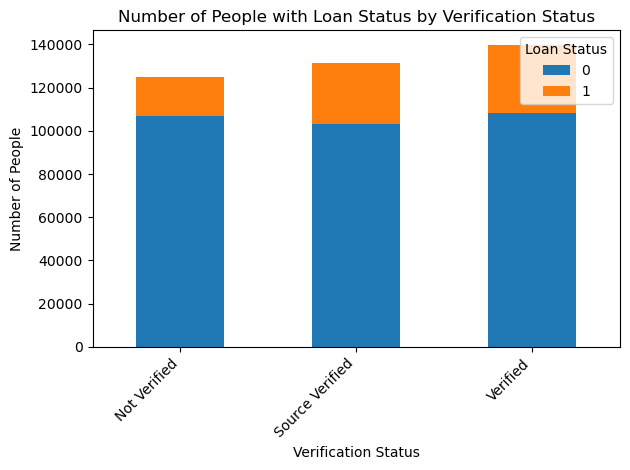

In [11]:
# Group data by verification status and loan status, and count occurrences
grouped_data = df.groupby(['verification_status', 'loan_status']).size().unstack(fill_value=0)
verification_status_counts = df['verification_status'].value_counts()

# Aggregate by verification status and sum the counts for each loan status
grouped_data = grouped_data.groupby(level=0).sum()

# Calculate the ratio for each verification status
ratio_by_verification_status = grouped_data[1] / grouped_data.sum(axis=1)

# Print the ratio for each verification status
print("Ratio for each verification status:")
for val, status in zip(ratio_by_verification_status, verification_status_counts.index):
    print(f"{status}: {val}, number of occurrences: {verification_status_counts[status]}")
    
# Plot histogram
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Verification Status')
plt.ylabel('Number of People')
plt.title('Number of People with Loan Status by Verification Status')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

Now we check if the term of loan. This might also be incorporated using one hot encoding. 

Ratio for each term length:
 36 months: 0.14635998784797172, number of occurrences: 302005
 60 months: 0.21474293108041254, number of occurrences: 94025


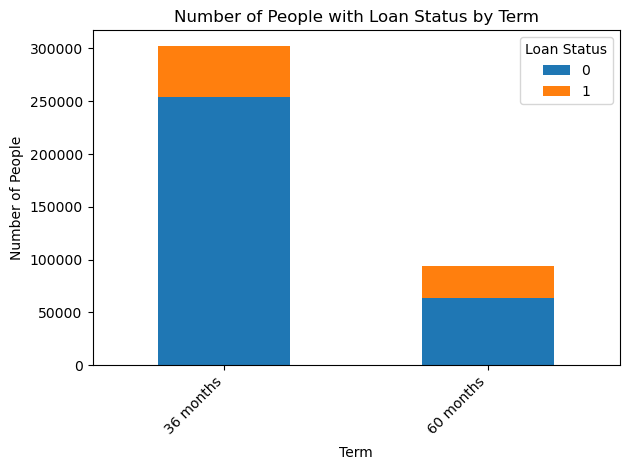

In [12]:
# Group data by verification status and loan status, and count occurrences
grouped_data = df.groupby(['term', 'loan_status']).size().unstack(fill_value=0)
verification_status_counts = df['term'].value_counts()

# Aggregate by verification status and sum the counts for each loan status
grouped_data = grouped_data.groupby(level=0).sum()

# Calculate the ratio for each verification status
ratio_by_term = grouped_data[1] / grouped_data.sum(axis=1)

# Print the ratio for each verification status
print("Ratio for each term length:")
for val, status in zip(ratio_by_verification_status, verification_status_counts.index):
    print(f"{status}: {val}, number of occurrences: {verification_status_counts[status]}")

# Plot histogram
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Term')
plt.ylabel('Number of People')
plt.title('Number of People with Loan Status by Term')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()


Now we check the home ownership. This might also be incorporated by using one hot encoding. We further see that certain types are insignificant. If we decide to use one hot encoding on this one we will drop those irrelevant columns. 

Ratio of Charged Off Loans for each Home Ownership Category:
ANY: 0.00% (Number of occurrences: 3)
MORTGAGE: 16.96% (Number of occurrences: 198348)
NONE: 22.58% (Number of occurrences: 31)
OTHER: 14.29% (Number of occurrences: 112)
OWN: 20.68% (Number of occurrences: 37746)
RENT: 22.66% (Number of occurrences: 159790)


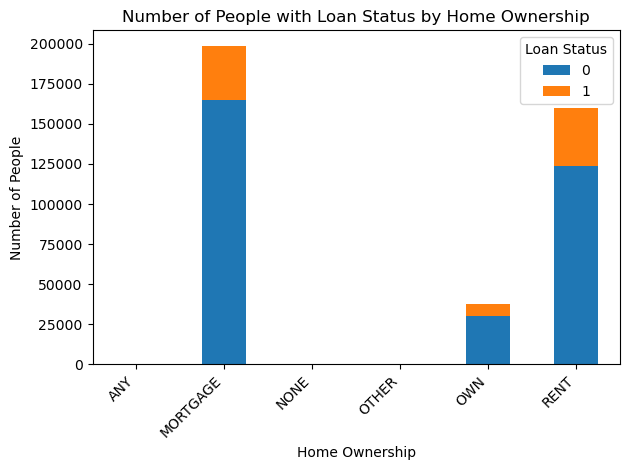

In [13]:
# Group data by home ownership and loan status, and count occurrences
grouped_data = df.groupby(['home_ownership', 'loan_status']).size().unstack(fill_value=0)
home_ownership_counts = df['home_ownership'].value_counts()

# Aggregate by home ownership and sum the counts for each loan status
grouped_data = grouped_data.groupby(level=0).sum()

# Calculate the ratio of Charged Off loans for each home ownership category
charged_off_ratio_by_home = (grouped_data[1] / grouped_data.sum(axis=1)) * 100

# Print the ratio for each home ownership category and number of occurrences
print("Ratio of Charged Off Loans for each Home Ownership Category:")
for home, ratio in zip(charged_off_ratio_by_home.index, charged_off_ratio_by_home):
    print(f"{home}: {ratio:.2f}% (Number of occurrences: {home_ownership_counts[home]})")

# Plot histogram
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Home Ownership')
plt.ylabel('Number of People')
plt.title('Number of People with Loan Status by Home Ownership')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

We check the public records and notice that there are cases with really few instances. 

In [14]:
df['pub_rec'] = df['pub_rec'].astype(str)
public_record_counts = df['pub_rec'].value_counts()

# Filter professions with counts greater than 100
#pub_rec_10 = public_record_counts
pub_rec_10 = public_record_counts[public_record_counts > 1]

aggregated_data_list = []

charged_off_ratios = []

# Aggregate data for each profession and append to aggregated_data_list
for pub_rec in pub_rec_10.index:
    # Filter data for the specific profession
    filtered_data = df[df['pub_rec'] == pub_rec]
    
    # Group filtered data by employment title and loan status, and count occurrences
    grouped_data = filtered_data.groupby(['pub_rec', 'loan_status']).size().unstack(fill_value=0)
    
    # Aggregate by employment title and sum the counts for each loan status
    grouped_data = grouped_data.groupby(level=0).sum()
    
    # Append to aggregated_data_list
    aggregated_data_list.append(grouped_data)

    # Calculate ratio of "Charged Off" cases to the total number of cases
    total_cases = grouped_data.sum(axis=1).sum()
    charged_off_cases = grouped_data[1].sum()
    charged_off_ratio = charged_off_cases / total_cases
    charged_off_ratios.append((pub_rec, charged_off_ratio))

print("Ratios of Charged Off cases to total cases for the corresponding public records:")
#decreasing order of charged off ratios
#charged_off_ratios.sort(key=lambda x: x[1], reverse=True)

for pub_rec, ratio in charged_off_ratios:
    print(f"{pub_rec}: {ratio:.2%}, number of cases: {public_record_counts[pub_rec]}")

Ratios of Charged Off cases to total cases for the corresponding public records:
0.0: 19.32%, number of cases: 338271
1.0: 21.05%, number of cases: 49739
2.0: 22.90%, number of cases: 5476
3.0: 22.35%, number of cases: 1521
4.0: 27.51%, number of cases: 527
5.0: 23.63%, number of cases: 237
6.0: 25.41%, number of cases: 122
7.0: 28.57%, number of cases: 56
8.0: 17.65%, number of cases: 34
9.0: 41.67%, number of cases: 12
10.0: 18.18%, number of cases: 11
11.0: 12.50%, number of cases: 8
13.0: 25.00%, number of cases: 4
12.0: 100.00%, number of cases: 4
19.0: 100.00%, number of cases: 2


In [15]:
# Convert 'pub_rec_bankruptcies' to string to facilitate grouping
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(str)

# Count occurrences of each level of 'pub_rec_bankruptcies'
pub_rec_bankruptcies_counts = df['pub_rec_bankruptcies'].value_counts()

# Filter 'pub_rec_bankruptcies' levels with counts greater than 1
pub_rec_bankruptcies_filtered = pub_rec_bankruptcies_counts[pub_rec_bankruptcies_counts > 1]

charged_off_ratios = []

# Aggregate data for each level of 'pub_rec_bankruptcies' and calculate charged-off ratio
for pub_rec_level in pub_rec_bankruptcies_filtered.index:
    # Filter data for the specific 'pub_rec_bankruptcies' level
    filtered_data = df[df['pub_rec_bankruptcies'] == pub_rec_level]
    
    # Group filtered data by loan status and count occurrences
    grouped_data = filtered_data.groupby('loan_status').size()
    
    # Calculate charged-off ratio
    total_cases = grouped_data.sum()
    charged_off_cases = grouped_data.get(1, 0)
    charged_off_ratio = charged_off_cases / total_cases if total_cases > 0 else 0
    
    # Append results to charged_off_ratios list
    charged_off_ratios.append((pub_rec_level, charged_off_ratio, total_cases))

# Print charged-off ratios and total cases for each level of 'pub_rec_bankruptcies'
print("Charged Off Ratios and Total Cases by Public Record of Bankruptcies Level:")
for pub_rec_level, charged_off_ratio, total_cases in charged_off_ratios:
    print(f"Public Record of Bankruptcies: {pub_rec_level}, Charged Off Ratio: {charged_off_ratio:.2%}, Total Cases: {total_cases}")

Charged Off Ratios and Total Cases by Public Record of Bankruptcies Level:
Public Record of Bankruptcies: 0.0, Charged Off Ratio: 19.50%, Total Cases: 350379
Public Record of Bankruptcies: 1.0, Charged Off Ratio: 20.39%, Total Cases: 42790
Public Record of Bankruptcies: 2.0, Charged Off Ratio: 23.23%, Total Cases: 1847
Public Record of Bankruptcies: nan, Charged Off Ratio: 16.42%, Total Cases: 536
Public Record of Bankruptcies: 3.0, Charged Off Ratio: 21.08%, Total Cases: 351
Public Record of Bankruptcies: 4.0, Charged Off Ratio: 31.71%, Total Cases: 82
Public Record of Bankruptcies: 5.0, Charged Off Ratio: 15.62%, Total Cases: 32
Public Record of Bankruptcies: 6.0, Charged Off Ratio: 28.57%, Total Cases: 7
Public Record of Bankruptcies: 7.0, Charged Off Ratio: 25.00%, Total Cases: 4
Public Record of Bankruptcies: 8.0, Charged Off Ratio: 50.00%, Total Cases: 2


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72444/2356801158.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['income_range', 'loan_status']).size().unstack(fill_value=0)
/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72444/2356801158.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = grouped_data.groupby(level=0).sum()


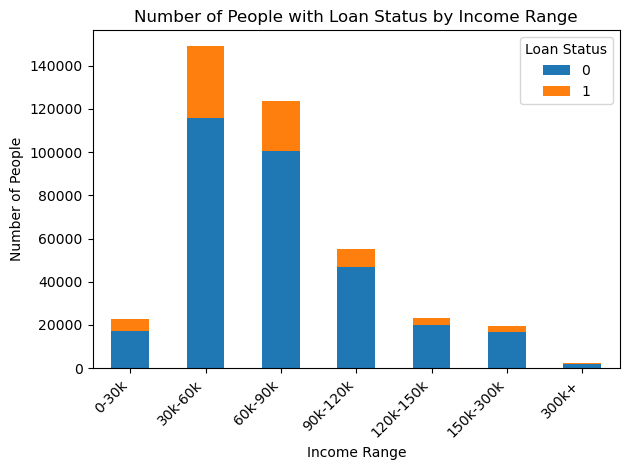

Income Range  | Charged Off Ratio (%)|  Count   
----------------------------------------------
0-30k         |  25.89%  | 22973 
30k-60k       |  22.34%  | 148871 
60k-90k       |  18.81%  | 123828 
90k-120k      |  15.59%  | 55209 
120k-150k     |  14.87%  | 23346 
150k-300k     |  14.35%  | 19522 
300k+         |  13.02%  | 2281 


In [16]:
# Define income ranges and bin labels
income_bins = [0, 30000, 60000, 90000, 120000, 150000, 300000, float('inf')]
bin_labels = ["0-30k", "30k-60k", "60k-90k", "90k-120k", "120k-150k", "150k-300k", "300k+"]

# Assign bin labels to each row based on annual_inc
df["income_range"] = pd.cut(df["annual_inc"], bins=income_bins, labels=bin_labels, right=False)

# Group data by income range and loan status, and count occurrences
grouped_data = df.groupby(['income_range', 'loan_status']).size().unstack(fill_value=0)
income_range_counts = df['income_range'].value_counts().sort_index()

# Aggregate by income range and sum the counts for each loan status
grouped_data = grouped_data.groupby(level=0).sum()

# Calculate the ratio of Charged Off loans for each income range
charged_off_ratio_by_income = (grouped_data[1] / grouped_data.sum(axis=1)) * 100



# Plot histogram
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Income Range')
plt.ylabel('Number of People')
plt.title('Number of People with Loan Status by Income Range')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

# Print number of individuals and "Charged Off" ratios for each income range
print("Income Range  | Charged Off Ratio (%)|  Count   ")
print("----------------------------------------------")
for income_range, ratio in zip(charged_off_ratio_by_income.index, charged_off_ratio_by_income):
    print(f"{income_range:<13} |  {ratio:.2f}%  | {income_range_counts[income_range]} ")

We though about removing some outliers, such as, 
- We remove clients with more than 5 public record of bankruptcies because they are few and they have (in general) super high default rate.
- We remove clients with more than 10 public records because they are few and they have (in general) super high default rate. 
- We remove clients with more than 300k annual income. (cannot be removed when using custom loss because they incur significant losses/profits)

But removing them didn't bring anything. These informations might be useful as in these extreme cases decisions are quite straightforward. 


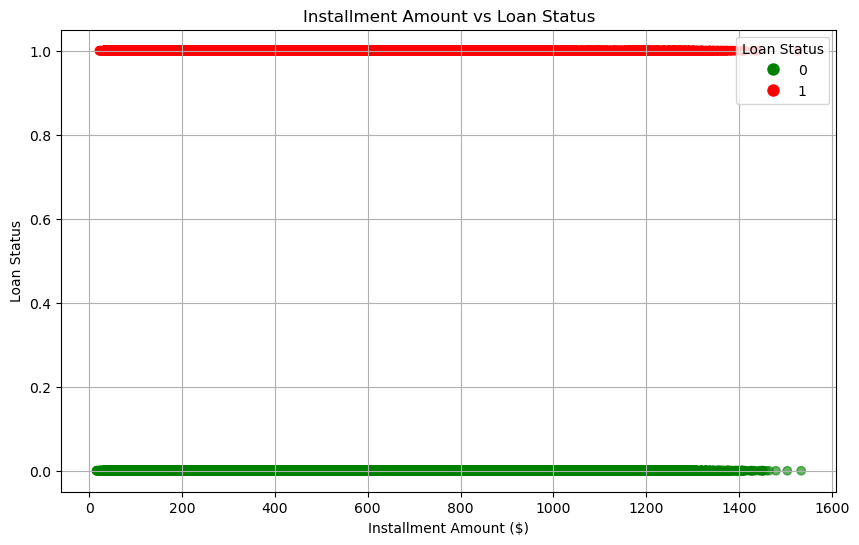

In [17]:
# Plotting Installment vs Loan Status
plt.figure(figsize=(10, 6))

# Create a scatter plot
colors = {0: 'green', 1: 'red'}  # Define colors for loan status
df['status_color'] = df['loan_status'].apply(lambda x: colors[x])
plt.scatter(df['installment'], df['loan_status'], c=df['status_color'], alpha=0.6)

# Adding labels and title
plt.xlabel('Installment Amount ($)')
plt.ylabel('Loan Status')
plt.title('Installment Amount vs Loan Status')

# Custom legend for loan status
statuses = list(colors.keys())
legend_markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[status], markersize=10, label=status) for status in statuses]
plt.legend(handles=legend_markers, title='Loan Status', loc='upper right')

# Show plot
plt.grid(True)
plt.show()

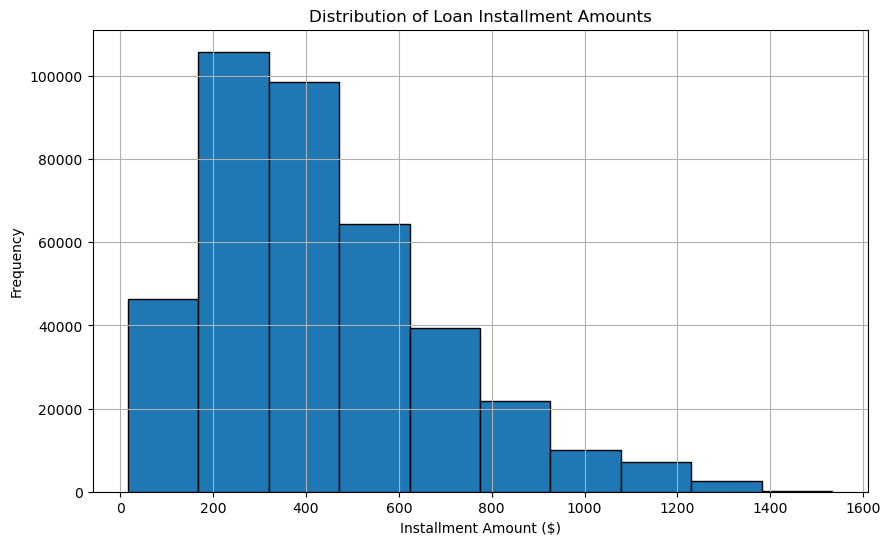

In [18]:
# Extract installment amounts from the DataFrame
installments = df['installment']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(installments, bins=10, edgecolor='black')  # Adjust 'bins' as needed for appropriate visualization
plt.title('Distribution of Loan Installment Amounts')
plt.xlabel('Installment Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

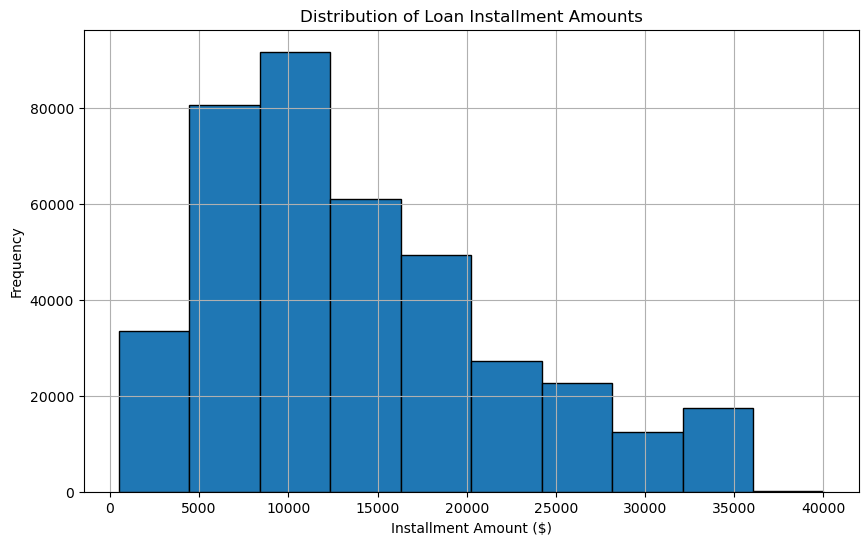

In [19]:
# Extract installment amounts from the DataFrame
installments = df['loan_amnt']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(installments, bins=10, edgecolor='black')  # Adjust 'bins' as needed for appropriate visualization
plt.title('Distribution of Loan Installment Amounts')
plt.xlabel('Installment Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

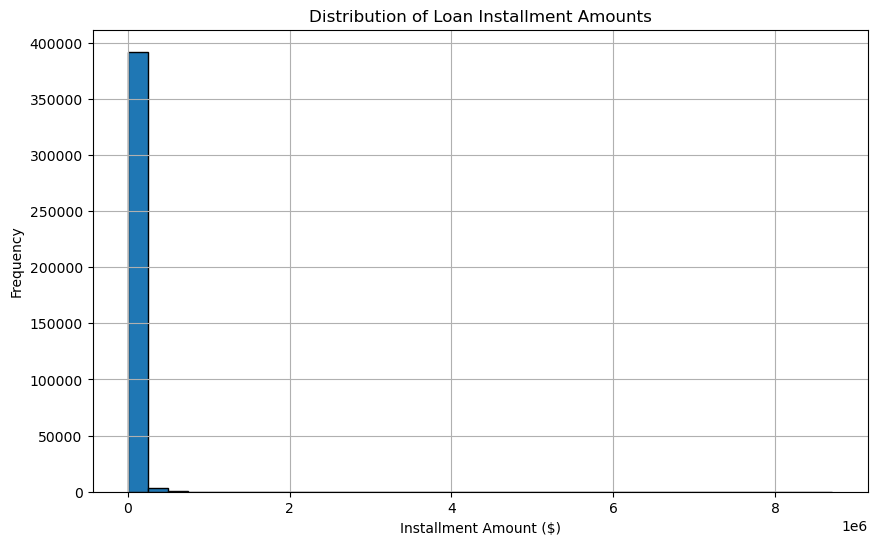

In [21]:
# Extract installment amounts from the DataFrame
installments = df['annual_inc']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(installments, bins=35, edgecolor='black')  # Adjust 'bins' as needed for appropriate visualization
plt.title('Distribution of Loan Installment Amounts')
plt.xlabel('Installment Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()